In [1]:
import numpy as np
import re
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Input

In [2]:
df_train = pd.read_csv('tweets_train.csv')
df_test = pd.read_csv('tweets_test.csv')
df_train.head(10)

,id,label,tweet
0,10027,1,someone find this man #stopracism
1,10028,0,this is our last weekend with nothing planned....
2,10029,0,@user i guess i'm going to sta watching @user...
3,10030,0,inside of the hotelð§ #vacation #mexico #riv...
4,10031,0,"turkey threw in the towel against spain, saysâ..."
5,10032,0,see the world differently. change your thought...
6,10033,0,time for drinks #holiday #cocktails #corfu @...
7,10034,0,who needs a #superhero when you have #daddy - ...
8,10035,0,#music as #therapy as a tool for #healing! #...
9,10036,0,@user @user @user brilliant! look forward to t...


In [3]:
df_test.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [4]:
# Total number of rows and columns in train dataset
df_train.shape

(21936, 3)

In [5]:
# Total number of rows and columns in train dataset
df_test.shape

(10026, 3)

In [6]:
df_train.describe()

,id,label
count,21936.000000,21936.000000
mean,20994.500000,0.070387
std,6332.522088,0.255803
min,10027.000000,0.000000
25%,15510.750000,0.000000
50%,20994.500000,0.000000
75%,26478.250000,0.000000
max,31962.000000,1.000000


In [7]:
df_test.describe()

,id,label
count,10026.000000,10026.000000
mean,5013.500000,0.069619
std,2894.401233,0.254516
min,1.000000,0.000000
25%,2507.250000,0.000000
50%,5013.500000,0.000000
75%,7519.750000,0.000000
max,10026.000000,1.000000


In [8]:
# Checking for null / empty values in train_df
has_missing_values_train = df_train.isnull().any().any()
if has_missing_values_train:
    print("The train dataframe contains missing values.")
else:
    print("The train dataframe does not contain any missing value.")

The train dataframe does not contain any missing value.


In [9]:
# Checking for null / empty values in test_df
has_missing_values_test = df_test.isnull().any().any()
if has_missing_values_test:
    print("The test dataframe contains missing values.")
else:
    print("The test dataframe does not contain any missing value.")

The test dataframe does not contain any missing value.


In [10]:
# Removing null/empty values if present
df_train = df_train.dropna(how='all')
df_test = df_test.dropna(how='all')

In [11]:
# Remove duplicate rows if present
df_train = df_train.drop_duplicates()
df_train.shape

(21936, 3)

In [12]:
df_test = df_test.drop_duplicates()
df_test.shape

(10026, 3)

In [13]:
# This method counts the number of occurrences of each unique value in the 'label' column
df_train['label'].value_counts()

0    20392
1     1544
Name: label, dtype: int64

In [14]:
# Removing unwanted 'id' column
del df_train['id']
del df_test['id']
df_train

,label,tweet
0,1,someone find this man #stopracism
1,0,this is our last weekend with nothing planned....
2,0,@user i guess i'm going to sta watching @user...
3,0,inside of the hotelð§ #vacation #mexico #riv...
4,0,"turkey threw in the towel against spain, saysâ..."
...,...,...
21931,0,ate @user isz that youuu?ðððððð...
21932,0,to see nina turner on the airwaves trying to...
21933,0,listening to sad songs on a monday morning otw...
21934,1,"@user #sikh #temple vandalised in in #calgary,..."


In [15]:
# Removing usernames from tweets using Regex
def keep_text(tweet_text, pattern):
    matching_txt = re.findall(pattern, tweet_text)
    for word in matching_txt:
        tweet_text = re.sub(word, "",tweet_text)
    return tweet_text

df_train['cleaned_tweet_text'] = np.vectorize(keep_text)(df_train['tweet'],"@[\w]*")
df_test['cleaned_tweet_text'] = np.vectorize(keep_text)(df_test['tweet'],"@[\w]*")

In [16]:
# Displaying tweets without username
df_train

,label,tweet,cleaned_tweet_text
0,1,someone find this man #stopracism,someone find this man #stopracism
1,0,this is our last weekend with nothing planned....,this is our last weekend with nothing planned....
2,0,@user i guess i'm going to sta watching @user...,i guess i'm going to sta watching #bringba...
3,0,inside of the hotelð§ #vacation #mexico #riv...,inside of the hotelð§ #vacation #mexico #riv...
4,0,"turkey threw in the towel against spain, saysâ...","turkey threw in the towel against spain, saysâ..."
...,...,...,...
21931,0,ate @user isz that youuu?ðððððð...,ate isz that youuu?ððððððð...
21932,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to...
21933,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...
21934,1,"@user #sikh #temple vandalised in in #calgary,...","#sikh #temple vandalised in in #calgary, #wso..."


In [17]:
df_test

,label,tweet,cleaned_tweet_text
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation
...,...,...,...
10021,1,@user oops! i did it again! melted another fra...,oops! i did it again! melted another fragile ...
10022,0,"@user how far has systemic hate come? first, ...","how far has systemic hate come? first, givin..."
10023,0,@user and that's what people don't get @user ...,and that's what people don't get if your no...
10024,0,17 tips to become right now! by @user,17 tips to become right now! by


In [18]:
# Keeping tweet text along with hashtags by removing other special characters
df_train["cleaned_tweet_text"] = df_train["cleaned_tweet_text"].str.replace("[^#a-zA-Z]", " ")
df_train

<ipython-input-18-6123e52e9688>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["cleaned_tweet_text"] = df_train["cleaned_tweet_text"].str.replace("[^#a-zA-Z]", " ")


,label,tweet,cleaned_tweet_text
0,1,someone find this man #stopracism,someone find this man #stopracism
1,0,this is our last weekend with nothing planned....,this is our last weekend with nothing planned ...
2,0,@user i guess i'm going to sta watching @user...,i guess i m going to sta watching #bringba...
3,0,inside of the hotelð§ #vacation #mexico #riv...,inside of the hotel #vacation #mexico #riv...
4,0,"turkey threw in the towel against spain, saysâ...",turkey threw in the towel against spain says ...
...,...,...,...
21931,0,ate @user isz that youuu?ðððððð...,ate isz that youuu ...
21932,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to...
21933,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...
21934,1,"@user #sikh #temple vandalised in in #calgary,...",#sikh #temple vandalised in in #calgary #wso...


In [19]:
df_test["cleaned_tweet_text"] = df_test["cleaned_tweet_text"].str.replace("[^#a-zA-Z]", " ")
df_test

<ipython-input-19-c7619576e797>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test["cleaned_tweet_text"] = df_test["cleaned_tweet_text"].str.replace("[^#a-zA-Z]", " ")


,label,tweet,cleaned_tweet_text
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide society now #motivation
...,...,...,...
10021,1,@user oops! i did it again! melted another fra...,oops i did it again melted another fragile ...
10022,0,"@user how far has systemic hate come? first, ...",how far has systemic hate come first givin...
10023,0,@user and that's what people don't get @user ...,and that s what people don t get if your no...
10024,0,17 tips to become right now! by @user,tips to become right now by


In [20]:
# Removing stopwords from tweets
nltk.download('stopwords')
stop_words=stopwords.words('english')
df_train["cleaned_tweet_text"] = df_train["cleaned_tweet_text"].apply(lambda tweet : " ".join([word for word in tweet.split() if (word not in stop_words)]))
df_test["cleaned_tweet_text"] = df_test["cleaned_tweet_text"].apply(lambda tweet : " ".join([word for word in tweet.split() if (word not in stop_words)]))
df_train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,tweet,cleaned_tweet_text
0,1,someone find this man #stopracism,someone find man #stopracism
1,0,this is our last weekend with nothing planned....,last weekend nothing planned staing next weeke...
2,0,@user i guess i'm going to sta watching @user...,guess going sta watching #bringbacknashville
3,0,inside of the hotelð§ #vacation #mexico #riv...,inside hotel #vacation #mexico #rivieramaya #i...
4,0,"turkey threw in the towel against spain, saysâ...",turkey threw towel spain says #spos # towel #a...
...,...,...,...
21931,0,ate @user isz that youuu?ðððððð...,ate isz youuu
21932,0,to see nina turner on the airwaves trying to...,see nina turner airwaves trying wrap mantle ge...
21933,0,listening to sad songs on a monday morning otw...,listening sad songs monday morning otw work sad
21934,1,"@user #sikh #temple vandalised in in #calgary,...",#sikh #temple vandalised #calgary #wso condemn...


In [21]:
df_test

,label,tweet,cleaned_tweet_text
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit use cause offer wheelchair...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,#model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society #motivation
...,...,...,...
10021,1,@user oops! i did it again! melted another fra...,oops melted another fragile snowflake #sad #so...
10022,0,"@user how far has systemic hate come? first, ...",far systemic hate come first giving shit trans...
10023,0,@user and that's what people don't get @user ...,people get florida know
10024,0,17 tips to become right now! by @user,tips become right


In [22]:
# Training data
Tweet_text = df_train['cleaned_tweet_text']
Tweet_sentiment = df_train['label']

# Test data
Test_tweet_text = df_test['cleaned_tweet_text']
Test_tweet_sentiment = df_test['label']

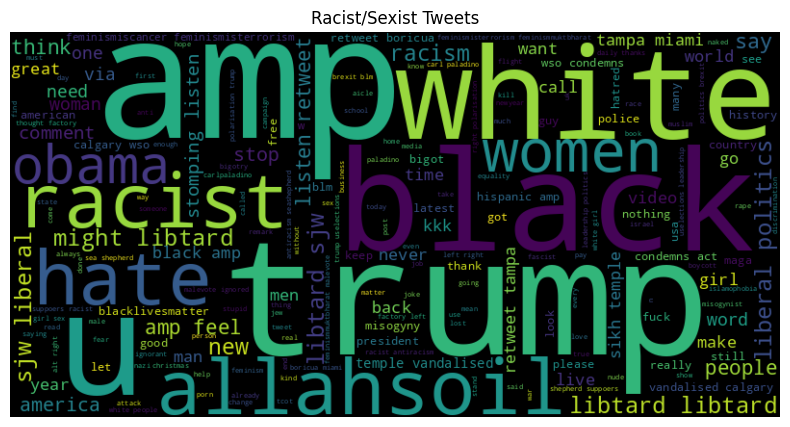

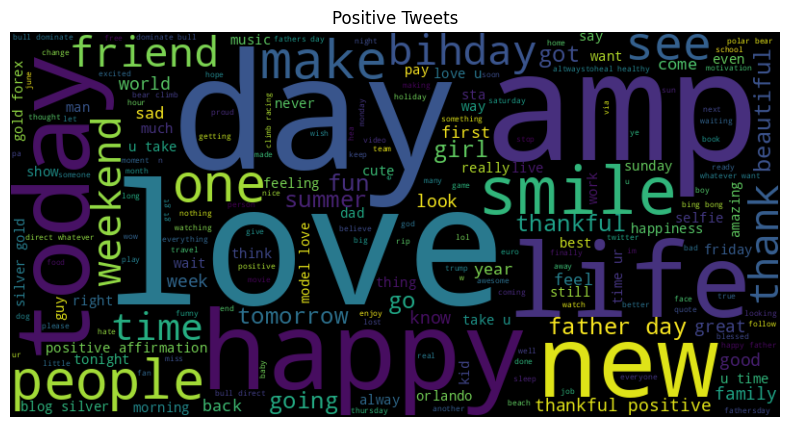

In [23]:
def wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, height=400, stopwords=set(STOPWORDS), background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()


negative = df_train[df_train['label']==1]['cleaned_tweet_text'].tolist()
wordcloud(negative,'Racist/Sexist Tweets')
positive = df_train[df_train['label']==0]['cleaned_tweet_text'].tolist()
wordcloud(positive,'Positive Tweets')

In [ ]:
# Splitting TEST data into test and validation
x_val, x_test, y_val, y_test = train_test_split(Test_tweet_text, Test_tweet_sentiment, test_size=0.5, stratify = Test_tweet_sentiment)

In [ ]:
#Tokenizaton and Encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Apply the BERT tokenization in training, testing and validation dataset
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Tweet_text.tolist(), padding=True, truncation=True, max_length = max_len, return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), padding=True, truncation=True, max_length = max_len, return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), padding=True, truncation=True, max_length = max_len, return_tensors='tf')

In [ ]:
k = 0
print('Training Tweet -->>',Tweet_text[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Tweet_sentiment[k])

Training Tweet -->> someone find man #stopracism

Input Ids -->>
 tf.Tensor(
[  101  2619  2424  2158  1001  2644 22648  2964   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)

Decoded Ids -->>
 [CLS] someone find man # stopracism [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer='adam', loss=loss, metrics=[metric])

In [ ]:
#Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Tweet_sentiment,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3
686/686 [==============================] - 40565s 59s/step - loss: 0.1806 - accuracy: 0.9446 - val_loss: 0.1171 - val_accuracy: 0.9633
Epoch 2/3
686/686 [==============================] - 16583s 24s/step - loss: 0.0873 - accuracy: 0.9713 - val_loss: 0.1000 - val_accuracy: 0.9643
Epoch 3/3
686/686 [==============================] - 62308s 91s/step - loss: 0.0439 - accuracy: 0.9852 - val_loss: 0.1135 - val_accuracy: 0.9647


In [ ]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

157/157 [==============================] - 854s 5s/step - loss: 0.1021 - accuracy: 0.9667
Test loss: 0.10208749026060104, Test accuracy: 0.9666866064071655


In [ ]:
path = 'new-folder'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')
# Save model
model.save_pretrained(path +'/Model')

In [ ]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')
# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at path-to-save/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at path-to-save/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Predict the sentiment of the test dataset
pred = bert_model.predict([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = { 1: 'Negative', 0: 'Positive' }

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

157/157 [==============================] - 815s 5s/step
Predicted Label : ['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive']
Actual Label    : ['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive']


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.77      0.74      0.76       349
    Positive       0.98      0.98      0.98      4664

    accuracy                           0.97      5013
   macro avg       0.88      0.86      0.87      5013
weighted avg       0.97      0.97      0.97      5013



In [ ]:
def generate_sentiment(Tweet, Tokenizer=bert_tokenizer, Model=bert_model):
    if not isinstance(Tweet, list):
        Tweet = [Tweet]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Tweet, padding=True, truncation=True, max_length=128, return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [ ]:
Tweet = 'The weather looks very pleasant and calm today, I am feeling happy!'
generate_sentiment(Tweet)

1/1 [==============================] - 3s 3s/step


['Positive']

In [ ]:
Tweet = 'the abuse experienced by women is often sexist or misogynistic in nature, and online threats of violence against women are often sexualized and include specific references to women’s bodies. The aim of violence and abuse is to create a hostile online environment for women with the goal of shaming, intimidating, degrading, belittling or silencing women.'
generate_sentiment(Tweet)

1/1 [==============================] - 0s 109ms/step


['Negative']